In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
import pandas as pd

import pickle
from scipy.spatial.distance import cityblock

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances



from sklearn.feature_selection import VarianceThreshold


In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:

def train_test(X, y, test_size = 0.2, random_state = 42):
    """Split a dataset into train and test sets and visualize the distribution of classes in the trainsets

    Args:
        X (pandas.DataFrame): The feature matrix of a dataset
        y (pandas.Series): The target variable of a dataset
        test_size (float, optional): The size of the test set. Defaults to 0.2.

    Returns:
        X_train (pandas.DataFrame): The feature matrix of the training set
        X_test (pandas.DataFrame): The feature matrix of the test set
        y_train (pandas.Series): The target variable of the training set
        y_test (pandas.Series): The target variable of the test set

    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    # visualize_class_distribution(y_train)
    

    print(f'Trainset ---> {y_train.value_counts()[0]} Inactive Compounds, {y_train.value_counts()[1]} Active Compounds')
    print(f'Testset ---> {y_test.value_counts()[0]} Inactive Compounds, {y_test.value_counts()[1]} Active Compounds')

    return X_train, X_test, y_train, y_test 



def sep_features_and_target(df, target = 'Activity'):
    """Divide the dataframe into X and y

    Args:
        df (pandas.DataFrame): The dataset
        target (str, optional): The target variable. Defaults to 'Activity'.

    Returns:
        X (pandas.DataFrame): The feature matrix of the dataset
        y (pandas.Series): The target variable of the dataset
    """
    X = df.drop([target], axis = 1)
    y = df[target]

    return X, y

def variance_filter(X_train, X_test, threshold = 0.0):
    """Remove features with low variance

    Args:
        train (pandas.DataFrame): The training set
        test (pandas.DataFrame): The test set
        threshold (float, optional): The threshold for variance. Defaults to 0.0.

    Returns:
        pandas.DataFrame: The filtered training set
        pandas.DataFrame: The filtered test set
    """
    
    print(f'Initial Shapes: X_train ---> {X_train.shape}, X_test ---> {X_test.shape}')
    
    vt = VarianceThreshold(threshold = threshold)
    
    #Fit
    _ = vt.fit(X_train)
    
    # Get the mask
    mask = vt.get_support()
    
    #Subset the DataFrame

    X_train = X_train.loc[:, mask]
    X_test = X_test.loc[:, mask]
    
    print(f'After Filter: X_train ---> {X_train.shape}, X_test ---> {X_test.shape}')

    return X_train, X_test, mask


def random_five_thousand(df, num = 5000):
    """Dataframe with 5000 inactive compounds and all active compounds

    Args:
        df (dataframe): the dataframe for the training data
        
    Returns:
        df (dataframe): the dataframe for the training data containing 5000 inactive plus all active compounds
    """
    
    df_0 = df.query('Activity == 0')
    df_1 = df.query('Activity == 1')
    
    print(f'Initial Number of Compounds: Inactives ---> {len(df_0)}, Actives ---> {len(df_1)}')
    
    df_0 = df_0.sample(n = num, random_state = 42)
    
    print(f'Final Number of Compounds: Inactives ---> {len(df_0)}, Actives ---> {len(df_1)}')
    
    df = pd.concat([df_0, df_1], ignore_index=True)
    
    return df
 

In [6]:
   
#load in the data
df = pd.read_csv('../Data/final_dataset.csv')
len(df)
#load in the data with the CIDs 
cid_df = pd.read_csv('../Data/data_with_CID.csv')
len(cid_df)


368931

In [8]:
#load in the duplicates mask
with open('../Data/duplicates_mask', 'rb') as f:
    duplicates_mask = pickle.load(f)
len(duplicates_mask)


4639

In [9]:
#filter the data to remove duplicates 
cid_df.drop(duplicates_mask, inplace = True)
len(cid_df)


364292

In [10]:

cid_df.head(5)
cid_df.columns


Index(['ReadIn_ID', 'USER_ID', 'D001', 'D002', 'D003', 'D004', 'D005', 'D006',
       'D007', 'D008',
       ...
       'D769', 'D770', 'D771', 'D772', 'D773', 'D774', 'D775', 'D776', 'D777',
       'Activity'],
      dtype='object', length=780)

In [11]:
#drop the Read_ln column
cid_df.drop('ReadIn_ID', axis = 1, inplace = True)
cid_df.head(5)


,USER_ID,D001,D002,D003,D004,D005,D006,D007,D008,D009,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,Activity
0,136153826,2,0,0,2,3,0,0,0,0,...,0,0,0,0,0,5.267,-0.711,0.379,1.885,1
1,136141512,2,0,0,0,3,0,0,0,0,...,0,0,0,0,0,5.426,-0.712,0.353,5.617,1
2,136141492,3,0,0,0,4,0,0,0,0,...,0,0,0,0,0,5.883,-0.678,0.383,8.837,1
3,136141488,3,0,0,0,4,0,0,0,0,...,0,0,0,0,0,5.807,-0.703,0.409,7.934,1
4,136141454,3,0,0,0,4,0,0,0,0,...,0,0,0,0,0,5.833,-0.710,0.400,7.255,1


In [12]:

#create data for the random 5000 iteration 
df_r_5000 = random_five_thousand(cid_df)


Initial Number of Compounds: Inactives ---> 362264, Actives ---> 2028
Final Number of Compounds: Inactives ---> 5000, Actives ---> 2028


# Applicability Domain Using the Standardization Approach

In [13]:
#divide the data into features including the CIDs and y
X, y = sep_features_and_target(df_r_5000)
print(X.shape)
print(y.shape)


(7028, 778)
(7028,)


In [14]:

#split the data into testing and training sets 
X_train, X_test, y_train, y_test1 = train_test(X,y)
#remove low variance features
X_train, X_test, mask1 = variance_filter(X_train, X_test)
X_train.head()
# retrieve the user ids from the train and test sets first and then drop that column 
X_train_cids = X_train['USER_ID']
X_test_cids = X_test['USER_ID']

X_train = X_train.drop('USER_ID', axis = 1)
X_test = X_test.drop('USER_ID', axis = 1)




Trainset ---> 3982 Inactive Compounds, 1640 Active Compounds
Testset ---> 1018 Inactive Compounds, 388 Active Compounds
Initial Shapes: X_train ---> (5622, 778), X_test ---> (1406, 778)
After Filter: X_train ---> (5622, 630), X_test ---> (1406, 630)


In [15]:


print(X_train_cids.shape)
print(X_test_cids.shape)
print(X_train.shape)
print(X_test.shape)
X_train.head(5)


(5622,)
(1406,)
(5622, 629)
(1406, 629)


,D001,D002,D003,D004,D005,D006,D007,D008,D010,D011,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
3977,2,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,5.16993,-0.781627,0.461538,2.35606
5309,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,5.12900,-0.234000,0.444000,4.96900
3404,2,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,5.32193,-0.785198,0.375000,3.01580
4428,2,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,4.70044,-0.763496,0.631579,4.43592
5513,1,0,0,1,2,0,0,0,0,0,...,0,0,2,1,0,0,5.52400,-0.229000,0.162000,2.21900


In [16]:

#plot the applicability domain based on the standardization approach 
#start with the train set 
#standardize all descriptors 
for column in X_train.columns: 
    #compute mean and standard deviation for the column/descriptor
    mean = X_train[column].mean()
    std = X_train[column].std()
    
    #standardize training set
    X_train[column] = (X_train[column] - mean)/std
    
    #standardize test set 
    X_test[column] = (X_test[column] - mean)/std

#calculate the maximum and minimum standardized descriptor value for each compound k
"""
first create empty lists to contain the compounds that are in the domain with their 
corresponding indices and those that are not in the domain with their corresponding indices. 
The indices would be used to locate their compound IDs. 
"""
in_domain_train = []
in_domain_indices_train = []
out_domain_train = []
out_domain_indices_train = []

for compound in range(len(X_train)):
    s_max = X_train.iloc[compound].max()
    if s_max >3:
        s_min = X_train.iloc[compound].min()
        if s_min > 3:
            out_domain_train.append(s_min)
            out_domain_indices_train.append(compound)
        else: 
            mean_des = X_train.iloc[compound].mean()
            std_des = X_train.iloc[compound].std()
            s_new = mean_des + (1.28 * std_des)
            if s_new>3:
                out_domain_train.append(s_new)
                out_domain_indices_train.append(compound)
            else:
                in_domain_train.append(s_new)
                in_domain_indices_train.append(compound)
    else:
        in_domain_train.append(s_max)
        in_domain_indices_train.append(compound)
        
#retrieve the compound cids for compounds inside the domain and those outside 
in_domain_cids_train = X_train_cids.iloc[in_domain_indices_train]
out_domain_cids_train = X_train_cids.iloc[out_domain_indices_train]


In [17]:
    
#calculate the percentage of the training data that are below the 3 threshold, hence are outliers
total_train = in_domain_train + out_domain_train
#get compounds above the 3 threshold 
above_threshold = [x for x in total_train if x>3 ]

percentage = len(above_threshold)/len(in_domain_train + out_domain_train) * 100

percentage 


1.92102454642476

In [18]:

#quality checks
print(len(total_train))
print(len(above_threshold))
print((len(above_threshold)/len(total_train))*100)
print(100-percentage)


5622
108
1.92102454642476
98.07897545357524


In [19]:
#plot the applicability domain based on the standardization approach 
#Do the test set 
#standardize all descriptors 
for column in X_test.columns: 
#     #compute mean and standard deviation for the column/descriptor
#     mean = X_test[column].mean()
#     std = X_test[column].std()
    
    #standardize test set
    X_test[column] = (X_test[column] - mean)/std
    


#calculate the maximum and minimum standardized descriptor value for each compound k
"""
first create empty lists to contain the compounds that are in the domain with their 
corresponding indices and those that are not in the domain with their corresponding indices. 
The indices would be used to locate their compound IDs. 
"""
in_domain_test = []
in_domain_indices_test = []
out_domain_test = []
out_domain_indices_test = []

for compound in range(len(X_test)):
    s_max = X_test.iloc[compound].max()
    if s_max >3:
        s_min = X_test.iloc[compound].min()
        if s_min > 3:
            out_domain_test.append(s_min)
            out_domain_indices_test.append(compound)
        else: 
            mean_des = X_test.iloc[compound].mean()
            std_des = X_test.iloc[compound].std()
            s_new = mean_des + (1.28 * std_des)
            if s_new>3:
                out_domain_test.append(s_new)
                out_domain_indices_test.append(compound)
            else:
                in_domain_test.append(s_new)
                in_domain_indices_test.append(compound)
    else:
        in_domain_test.append(s_max)
        in_domain_indices_test.append(compound)
        
        
#retrieve the compound cids for compounds inside the domain and those outside 
in_domain_cids_test = X_test_cids.iloc[in_domain_indices_test]
out_domain_cids_test = X_test_cids.iloc[out_domain_indices_test]


In [20]:
    
#calculate the percentage of the training data that are below the 3 threshold, hence are outliers
total_test = in_domain_test + out_domain_test
#get compounds above the 3 threshold 
above_threshold = [x for x in total_test if x>3 ]

percentage = len(above_threshold)/len(in_domain_test + out_domain_test) * 100

percentage 

0.4978662873399715

In [21]:

#quality checks
print(len(total_test))
print(len(above_threshold))
print((len(above_threshold)/len(total_test))*100)
print(100-percentage)


1406
7
0.4978662873399715
99.50213371266003


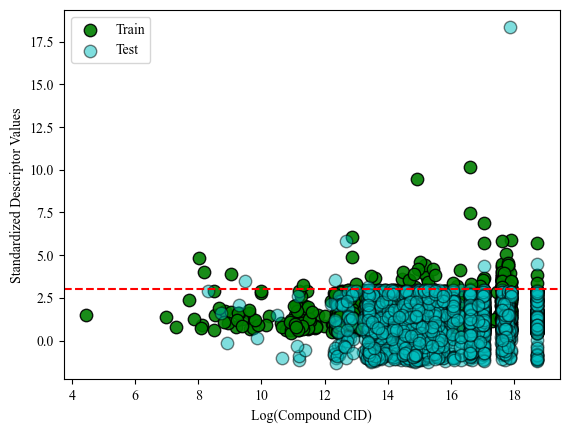

In [29]:

#plot the applicability domain for the training dataset
#fig,ax = plt.subplots()
plt.scatter(np.log(in_domain_cids_train), in_domain_train, color = 'g',  s=80, alpha=0.9, label="Train", marker="o", edgecolors='black')
plt.scatter(np.log(out_domain_cids_train), out_domain_train,color = 'g',  s=80, alpha=0.9, marker="o", edgecolors='black')


#plot the applicability domain for the training dataset
#fig,ax = plt.subplots()
plt.scatter(np.log(in_domain_cids_test), in_domain_test, color = 'c', s=80, alpha=0.5, label="Test", marker="o", edgecolors='black' )
plt.scatter(np.log(out_domain_cids_test), out_domain_test, color = 'c', s=80, alpha=0.5, marker="o", edgecolors='black')
plt.axhline(3, color = 'red', ls= '--')
plt.xlabel("Log(Compound CID)" )
plt.ylabel("Standardized Descriptor Values")
#plt.title('Applicability Domain Analysis Using \n Standardized Descriptor Values ')
plt.legend()
plt.savefig('../Results/Applicability domain_no_title.pdf')
